In [ ]:
# --- 1. Setup ---
import os
import nltk
%pip install transformers torch --quiet
from nltk import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline

# Download required NLTK data
nltk.download("punkt")
nltk.download("vader_lexicon")

# Paths
input_dir = "../data/chapters"

# Tools
sia = SentimentIntensityAnalyzer()
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

: 

In [ ]:
vader_results = []

for filename in sorted(os.listdir(input_dir)):
    if filename.endswith(".txt"):
        with open(os.path.join(input_dir, filename), "r", encoding="utf-8") as f:
            text = f.read()

        sentences = sent_tokenize(text)
        scores = [sia.polarity_scores(s)["compound"] for s in sentences]
        avg_score = sum(scores) / len(scores) if scores else 0

        vader_results.append({
            "chapter": filename,
            "vader_avg": avg_score,
            "vader_min": min(scores, default=0),
            "vader_max": max(scores, default=0)
        })

df_vader = pd.DataFrame(vader_results)
df_vader

,chapter,positive,neutral,negative,compound
0,chapter_1.txt,0.104,0.826,0.069,0.9999
1,chapter_10.txt,0.084,0.849,0.067,0.9904
2,chapter_2.txt,0.091,0.844,0.065,0.9996
3,chapter_3.txt,0.112,0.811,0.077,0.9999
4,chapter_4.txt,0.096,0.812,0.092,0.9853
5,chapter_5.txt,0.079,0.819,0.102,-0.9968
6,chapter_6.txt,0.115,0.803,0.082,0.9999
7,chapter_7.txt,0.093,0.828,0.078,0.9999
8,chapter_8.txt,0.092,0.822,0.086,0.9987
9,chapter_9.txt,0.084,0.841,0.075,0.9991


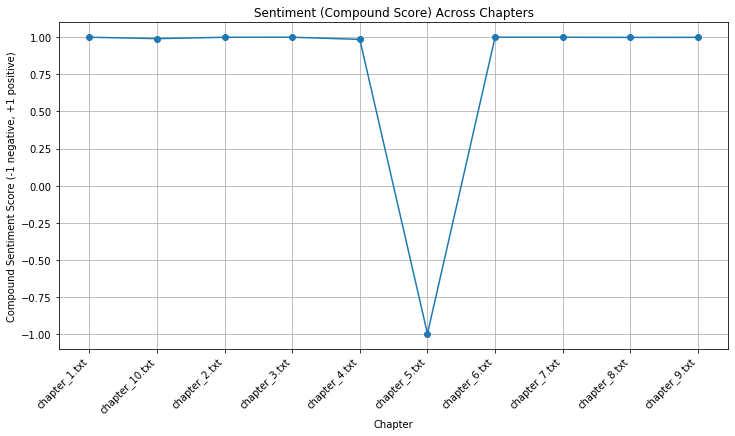

In [ ]:
hf_results = []

for filename in sorted(os.listdir(input_dir)):
    if filename.endswith(".txt"):
        with open(os.path.join(input_dir, filename), "r", encoding="utf-8") as f:
            text = f.read()

        # Transformer models have a max input length (~512 tokens), so we chunk
        chunks = [text[i:i+1000] for i in range(0, len(text), 1000)]
        chunk_scores = []

        for chunk in chunks:
            result = classifier(chunk)[0]  # {'label': 'POSITIVE', 'score': 0.99}
            score = result["score"] if result["label"] == "POSITIVE" else -result["score"]
            chunk_scores.append(score)

        avg_score = sum(chunk_scores) / len(chunk_scores) if chunk_scores else 0

        hf_results.append({
            "chapter": filename,
            "hf_avg": avg_score,
            "hf_min": min(chunk_scores, default=0),
            "hf_max": max(chunk_scores, default=0)
        })

df_hf = pd.DataFrame(hf_results)
df_hf

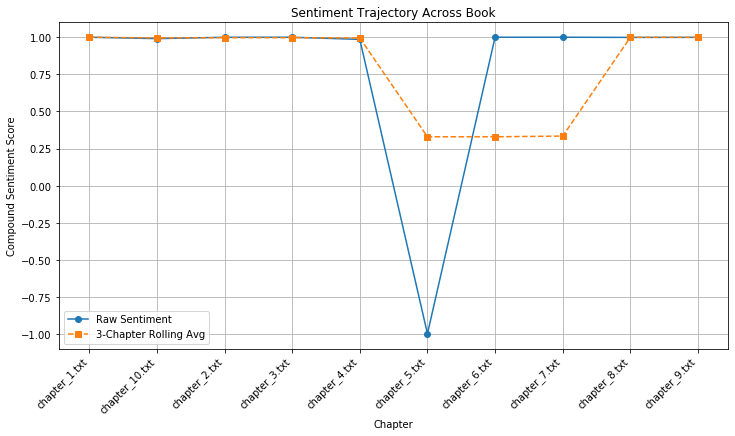

In [ ]:
df = pd.merge(df_vader, df_hf, on="chapter")
df

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df["chapter"], df["vader_avg"], marker="o", label="VADER (lexicon)")
plt.plot(df["chapter"], df["hf_avg"], marker="s", linestyle="--", label="Transformer (DistilBERT)")
plt.xticks(rotation=45, ha="right")
plt.title("Sentiment Trajectory Across Chapters")
plt.xlabel("Chapter")
plt.ylabel("Average Sentiment Score (-1 negative, +1 positive)")
plt.legend()
plt.grid(True)
plt.show()

ModuleNotFoundError: No module named 'transformers'